# Imports

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Constants

In [2]:
prices = np.asarray([500, 300, 200])
capacity = 101  # 100 seats + 0 seats
time = np.arange(1, 601)

mui = np.asarray([0.001, 0.015, 0.05])
vi = np.asarray([0.01, 0.005, 0.0025])
probs = mui[:, None]*np.exp(np.outer(vi, time)) # lambda
probs[1, :] += probs[0, :]
probs[2, :] += probs[1, :]  # Cumulative probability of someone willing to pay 500/300/200

# Question A

In [3]:
value_matrix = np.zeros((capacity, 600)) # revenue
alpha_matrix = np.zeros((capacity, 600)) # policy
value_matrix[0, :] = 0  # If no seats are left revenue is always 0
alpha_matrix[0, :] = np.nan # If no seats are left there is no policy

for t in reversed(time):
    t -=1
    for state in range(1, capacity):
        if t == 599:
            values = probs[:, t]*prices
        else:
            values = probs[:, t]*prices + \
                     probs[:, t]*value_matrix[state-1, t+1] + \
                     (1-probs[:, t])*value_matrix[state, t+1] # expected revenue from current state + next state

        value_matrix[state, t] = values.max()
        alpha_matrix[state, t] = prices[values.argmax()]

In [4]:
value_matrix[100, 0]

30457.82127594222

# Question B

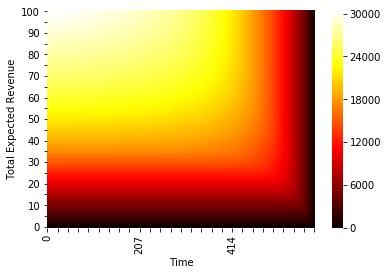

In [5]:
ax = sns.heatmap(value_matrix, cmap='hot')
ax.invert_yaxis()
ax.set(xlabel='Time', ylabel='Total Expected Revenue')

for label in ax.get_xticklabels():
    if np.int(label.get_text()) % 9 == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)
        
for label in ax.get_yticklabels():
    if np.int(label.get_text()) % 10 == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)

fig = ax.get_figure()

fig.savefig('revenue_plot.png')

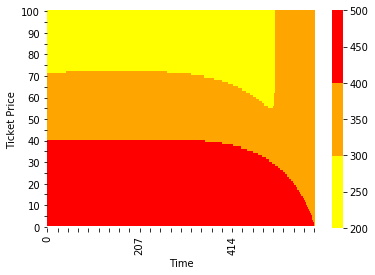

In [6]:
ax = sns.heatmap(alpha_matrix, cmap=['yellow', 'orange', 'red'])
ax.invert_yaxis()
ax.set(xlabel='Time', ylabel='Ticket Price')


for label in ax.get_xticklabels():
    if np.int(label.get_text()) % 9 == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)
        
for label in ax.get_yticklabels():
    if np.int(label.get_text()) % 10 == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)

fig = ax.get_figure()
fig.savefig('policy_plot.png')

# Question C

In [7]:
def simulate(probs, alpha_matrix, capacity=99, time=600):
    revenue = [0]
    capacities = [capacity]
    prices_t = []
    ticket_sold = []
    
    for t in np.arange(time):
        p = np.random.uniform()
        anarray = np.where((probs[:, t] > p) == True)[0]
        
        if anarray.size > 0:
            wtp = prices[min(anarray)] # want to pay
        else:
            wtp = 0
            
        price = alpha_matrix[capacities[-1], t] # current price

        prices_t.append(price)
        
        if (wtp >= price) and (capacities[-1] > 0): # if someone is willing to pay, a ticket is sold
            capacities.append(capacities[-1]-1)
            revenue.append(revenue[-1] + price)
            ticket_sold.append(price)
        else: # if nobody is willing to pay, no tickets are sold
            capacities.append(capacities[-1])
            revenue.append(revenue[-1])
            ticket_sold.append(np.nan)
            
    return np.asarray([revenue[1:]]), np.asarray([capacities[1:]]), np.asarray([prices_t]), np.asarray([ticket_sold])

In [8]:
# run simulation 500 times
its = 500
revenues = np.zeros((its, 600))
capacities = np.zeros((its, 600))
prices_t = np.zeros((its, 600))
ticket_sold = np.zeros((its, 600))

for i in np.arange(its):
    r, c, p, t = simulate(probs, alpha_matrix)
    revenues[i, :] = r
    capacities[i, :] = c
    prices_t[i, :] = p
    ticket_sold[i, :] = t

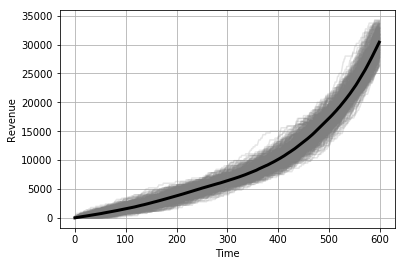

In [9]:
# plot the revenues and mean revenues
plt.plot(revenues.T, c='gray', alpha = 0.2)
plt.plot(revenues.mean(axis=0), c='black', linewidth=3)
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.grid()
plt.savefig('Revenue_sim_1.png')
plt.show()

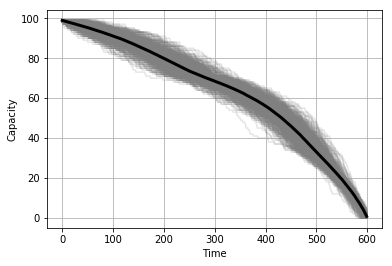

In [10]:
# plot the capacities and mean capacities
plt.plot(capacities.T, c='gray', alpha = 0.2)
plt.plot(capacities.mean(axis=0), c='black', linewidth=3)
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.grid()
plt.savefig('Capacity_sim_1.png')
plt.show()

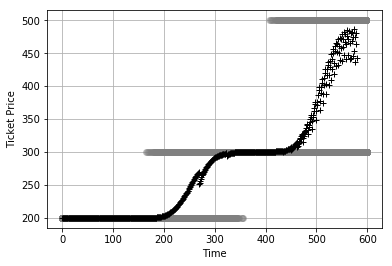

In [11]:
# plot prices and mean prices
plt.plot(prices_t.T, 'o', c='gray', alpha = 0.2)
plt.plot(prices_t.mean(axis=0), '+', c='black', linewidth=3)
plt.xlabel('Time')
plt.ylabel('Ticket Price')
plt.grid()
plt.savefig('Prices_sim_1.png')
plt.show()

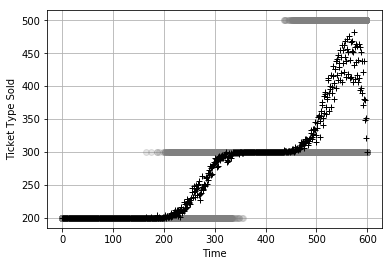

In [12]:
# plot tickets sold and mean tickets sold
plt.plot(ticket_sold.T, 'o', c='gray', alpha = 0.2)
plt.plot(np.nanmean(ticket_sold, axis=0), '+', c='black', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Ticket Type Sold')
plt.grid()
plt.savefig('Sales_sim_1.png')
plt.show()

# Question D

In [13]:
value_matrix = np.zeros((capacity, 600))
alpha_matrix = np.zeros((capacity, 600))
value_matrix[0, :] = 0  # If no seats are left revenue is always 0
alpha_matrix[0, :] = np.nan # If no seats are left there is no policy

for t in reversed(time):
    t -= 1
    for state in range(1, capacity):
        
        values = probs[:, t]*prices          
        if t != 599:
            # use penalty if price goes down in next state/time
            values += probs[:, t]*value_matrix[state-1, t+1]*(alpha_matrix[state-1, t+1] >= prices)
            values += (1-probs[:, t])*(value_matrix[state, t+1])*(alpha_matrix[state, t+1] >= prices)
        
   
        value_matrix[state, t] = values.max()
        alpha_matrix[state, t] = prices[values.argmax()]
          

/usr/lib/python3/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater_equal
  del sys.path[0]


In [14]:
value_matrix[100, 0]

25799.692611049424

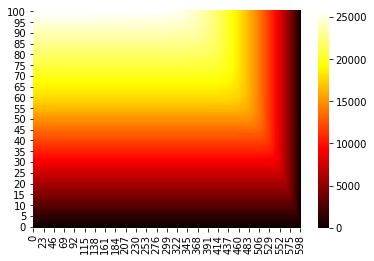

In [15]:
# plot revenues
ax = sns.heatmap(value_matrix, cmap='hot')
ax.invert_yaxis()

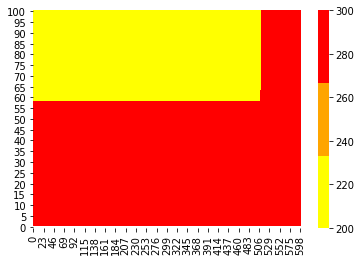

In [16]:
# plot policies
ax = sns.heatmap(alpha_matrix, cmap=['yellow', 'orange', 'red'])
ax.invert_yaxis()

In [17]:
# run simulation 500 times
its = 500
revenues = np.zeros((its, 600))
capacities = np.zeros((its, 600))
prices_t = np.zeros((its, 600))
ticket_sold = np.zeros((its, 600))

for i in np.arange(its):
    r, c, p, t = simulate(probs, alpha_matrix)
    revenues[i, :] = r
    capacities[i, :] = c
    prices_t[i, :] = p
    ticket_sold[i, :] = t

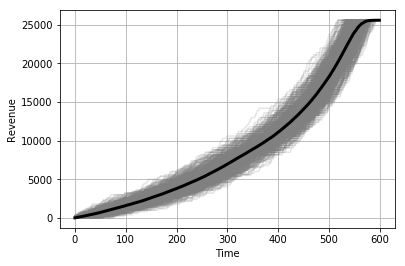

In [18]:
plt.plot(revenues.T, c='gray', alpha = 0.2)
plt.plot(revenues.mean(axis=0), c='black', linewidth=3)
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.grid()
plt.savefig('Revenue_sim_2.png')
plt.show()

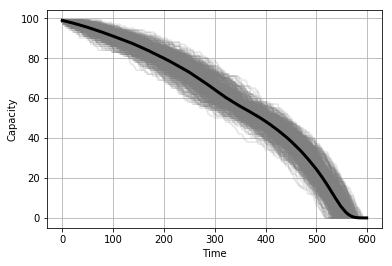

In [19]:
plt.plot(capacities.T, c='gray', alpha = 0.2)
plt.plot(capacities.mean(axis=0), c='black', linewidth=3)
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.grid()
plt.savefig('Capacity_sim_2.png')
plt.show()

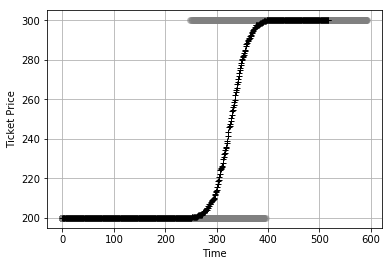

In [20]:
plt.plot(prices_t.T, 'o', c='gray', alpha = 0.2)
plt.plot(prices_t.mean(axis=0), '+', c='black', linewidth=3)
plt.xlabel('Time')
plt.ylabel('Ticket Price')
plt.grid()
plt.savefig('Prices_sim_2.png')
plt.show()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


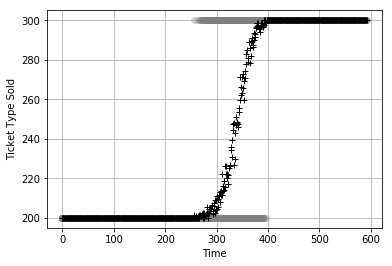

In [21]:
plt.plot(ticket_sold.T, 'o', c='gray', alpha = 0.2)
plt.plot(np.nanmean(ticket_sold, axis=0), '+', c='black', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Ticket Type Sold')
plt.grid()
plt.savefig('Sales_sim_2.png')
plt.show()